In [251]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re
from datetime import datetime

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.s3 import S3Uploader, S3Downloader

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

%cd /root/predicting-coronavirus
%pip install mpu
import src.data_import as di
#import src.data_tools as dt
import src.airport_index as ap

%matplotlib inline
pd.set_option('display.max_columns', 500)  
pd.set_option('display.max_rows', 500)   

/root/predicting-coronavirus
Note: you may need to restart the kernel to use updated packages.


In [242]:
!cd data/covid-19-data;git pull origin master

From https://github.com/nytimes/covid-19-data
 * branch            master     -> FETCH_HEAD
Already up to date.


In [305]:
#etl = dt.etl()
#nyt = etl.load_nyt()
nyt = di.extract_nyt()

In [306]:
#Get the maximum cases and deaths for each fips
max_cases = nyt.groupby('fips').max()
max_cases = max_cases[['cases', 'deaths']]
#max_cases['deaths'].sum()
#max_cases

In [307]:
sip = di.extract_sip()
election = di.extract_election()
geo = di.extract_geography()

<class 'pandas.core.series.Series'>


In [308]:
counties = ap.extract_geography()
airports = ap.extract_airports()
intl_index = ap.build_intl_arrivals_index_df2(counties, airports, 30, 200)

In [310]:
per100k = pd.merge(geo, nyt, how='inner', left_on=['fips'], right_on=['fips'])
per100k = per100k[['fips', 'population', 'date', 'cases', 'deaths']]
per100k['deaths_per'] = per100k.apply(lambda row: (row['deaths']/row['population'])*100000, axis=1)
per100k['cases_per'] = per100k.apply(lambda row: (row['cases']/row['population'])*100000, axis=1)


In [311]:
ten = per100k[per100k['cases_per'] > 10].groupby('fips').min()
ten = ten[['date']]
ten.columns = ['date_10']
#ten['date_10'].fillna(datetime(2020,5,15))

In [333]:
big_df = pd.merge(geo, election, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, intl_index[['fips', 'international']], how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, sip, how='left', left_on=['state'], right_on=['state'])

big_df = pd.merge(big_df, max_cases, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, ten, how='inner', left_on=['fips'], right_on=['fips'])


In [359]:
big_df.describe()

,fips,population,area-km,per_dem,per_gop,international,cases,deaths,pop_density,case_rate,death_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k
count,2820.000000,2.820000e+03,2820.000000,2820.000000,2820.000000,2.820000e+03,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000
mean,30302.599291,1.054444e+05,2614.574228,0.327583,0.625804,7.639358e+05,409.098936,21.587589,87.993192,235.437494,9.644964,43.921277,7.786879,41.693972
std,15254.497285,3.210556e+05,8263.176828,0.151485,0.154797,2.199438e+06,2137.168608,122.694525,304.761357,538.637457,21.203961,15.363013,7.403270,10.749739
min,1001.000000,6.470000e+02,5.177000,0.036364,0.041221,1.000000e+00,1.000000,0.000000,0.014828,10.004002,0.000000,0.000000,0.000000,4.000000
25%,18124.500000,1.393575e+04,1091.285750,0.214027,0.537484,1.000000e+00,9.000000,0.000000,8.722704,47.525706,0.000000,44.000000,0.000000,38.000000
50%,29096.000000,2.959900e+04,1532.338500,0.295843,0.654505,1.704712e+04,32.000000,1.000000,19.997195,99.911660,2.049002,46.000000,11.000000,44.000000
75%,45075.500000,7.623475e+04,2311.932250,0.412589,0.741344,4.427140e+05,141.250000,5.000000,51.077695,237.247587,9.017548,53.000000,15.000000,49.000000
max,56043.000000,9.818605e+06,376855.656000,0.928466,0.952727,2.412791e+07,53381.000000,2425.000000,6632.907743,17318.932656,272.055966,57.000000,21.000000,67.000000


In [334]:
big_df

,sc,fips,state,county,population,area-km,per_dem,per_gop,international,sip,sip_lifted,cases,deaths,date_10
0,Alabama:Autauga,1001,Alabama,Autauga,54571,1539.582,0.239569,0.734358,1.000000,2020-04-03,2020-04-30,84,4,2020-03-26
1,Alabama:Baldwin,1003,Alabama,Baldwin,182265,4117.522,0.195653,0.773515,1.000000,2020-04-03,2020-04-30,224,6,2020-03-31
2,Alabama:Barbour,1005,Alabama,Barbour,27457,2291.819,0.466603,0.522714,1.000000,2020-04-03,2020-04-30,61,1,2020-04-06
3,Alabama:Bibb,1007,Alabama,Bibb,22915,1612.481,0.214220,0.769662,1.000000,2020-04-03,2020-04-30,46,1,2020-03-31
4,Alabama:Blount,1009,Alabama,Blount,57322,1669.962,0.084699,0.898519,1.000000,2020-04-03,2020-04-30,45,0,2020-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,Wyoming:Sublette,56035,Wyoming,Sublette,10247,12656.072,0.149872,0.793344,1.000000,2020-05-15,2020-05-15,3,0,2020-04-09
2816,Wyoming:Sweetwater,56037,Wyoming,Sweetwater,43806,27004.897,0.194046,0.729428,1.000000,2020-05-15,2020-05-15,20,0,2020-04-05
2817,Wyoming:Teton,56039,Wyoming,Teton,21294,10347.984,0.600608,0.321945,1.000000,2020-05-15,2020-05-15,98,1,2020-03-24
2818,Wyoming:Uinta,56041,Wyoming,Uinta,21118,5390.450,0.149261,0.764187,179025.335253,2020-05-15,2020-05-15,9,0,2020-04-06


In [335]:
def days_since(row):
    row['days_since_sip'] = int((datetime(2020,5,15) - row['sip']).days)
    lifted = int((datetime(2020,5,15) - row['sip_lifted']).days)
    if(lifted < 0):
        lifted = 0
    row['days_since_sip_lifted'] = lifted
    ten_per = row['date_10']
    if pd.isnull(ten_per):
        row['days_since_10p100k'] = 0
    else:
        row['days_since_10p100k'] = int((datetime(2020,5,15) - ten_per).days)
    return row

big_df['pop_density'] = big_df['population']/big_df['area-km']
big_df['case_rate'] = big_df['cases']/big_df['population']*100000
big_df['death_rate'] = big_df['deaths']/big_df['population']*100000
big_df['case_rate'] = big_df['case_rate'].fillna(0)
big_df['death_rate'] = big_df['death_rate'].fillna(0)
big_df = big_df.apply(days_since, axis=1)



clean_df = big_df.drop(['population', 'area-km', 'cases', 'deaths', 'sip', 'sip_lifted', 'date_10'], axis=1)



In [336]:
clean_df.corr()

,fips,per_dem,per_gop,international,pop_density,case_rate,death_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k
fips,1.000000,-0.061065,0.053053,-0.028189,0.031019,-0.055539,-0.111604,0.114109,-0.023195,-0.108885
per_dem,-0.061065,1.000000,-0.983170,0.267531,0.398123,0.170879,0.264812,0.128912,-0.171427,0.309475
per_gop,0.053053,-0.983170,1.000000,-0.247570,-0.390821,-0.154709,-0.234437,-0.130005,0.190700,-0.305834
international,-0.028189,0.267531,-0.247570,1.000000,0.444047,0.266540,0.430344,0.134162,-0.108279,0.223216
pop_density,0.031019,0.398123,-0.390821,0.444047,1.000000,0.181931,0.279369,0.088396,-0.116545,0.177622
case_rate,-0.055539,0.170879,-0.154709,0.266540,0.181931,1.000000,0.469193,-0.009975,-0.025025,0.193324
death_rate,-0.111604,0.264812,-0.234437,0.430344,0.279369,0.469193,1.000000,0.102971,-0.047567,0.312946
days_since_sip,0.114109,0.128912,-0.130005,0.134162,0.088396,-0.009975,0.102971,1.000000,0.197474,0.091431
days_since_sip_lifted,-0.023195,-0.171427,0.190700,-0.108279,-0.116545,-0.025025,-0.047567,0.197474,1.000000,0.032268
days_since_10p100k,-0.108885,0.309475,-0.305834,0.223216,0.177622,0.193324,0.312946,0.091431,0.032268,1.000000


In [364]:
clean_df.describe()

,fips,per_dem,per_gop,international,pop_density,case_rate,death_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k
count,2820.000000,2820.000000,2820.000000,2.820000e+03,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000
mean,30302.599291,0.327583,0.625804,7.639358e+05,87.993192,235.437494,9.644964,43.921277,7.786879,41.693972
std,15254.497285,0.151485,0.154797,2.199438e+06,304.761357,538.637457,21.203961,15.363013,7.403270,10.749739
min,1001.000000,0.036364,0.041221,1.000000e+00,0.014828,10.004002,0.000000,0.000000,0.000000,4.000000
25%,18124.500000,0.214027,0.537484,1.000000e+00,8.722704,47.525706,0.000000,44.000000,0.000000,38.000000
50%,29096.000000,0.295843,0.654505,1.704712e+04,19.997195,99.911660,2.049002,46.000000,11.000000,44.000000
75%,45075.500000,0.412589,0.741344,4.427140e+05,51.077695,237.247587,9.017548,53.000000,15.000000,49.000000
max,56043.000000,0.928466,0.952727,2.412791e+07,6632.907743,17318.932656,272.055966,57.000000,21.000000,67.000000


In [362]:
save_df = clean_df.drop(['death_rate', 'sc', 'state', 'county','fips'], axis=1).set_index('case_rate')
save_trainval, save_test = train_test_split(save_df, test_size=.1) 
save_train, save_val = train_test_split(save_trainval, test_size=.1) 

save_train.to_csv('./data/btrain.csv', header=False)
save_val.to_csv('./data/bval.csv', header=False)
save_test.to_csv('./data/btest.csv', header=False)
save_df.to_csv('./data/bmerged.csv')

In [363]:
save_train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2284 entries, 56.57708628005658 to 120.3852327447833
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   per_dem                2284 non-null   float64
 1   per_gop                2284 non-null   float64
 2   international          2284 non-null   float64
 3   pop_density            2284 non-null   float64
 4   days_since_sip         2284 non-null   int64  
 5   days_since_sip_lifted  2284 non-null   int64  
 6   days_since_10p100k     2284 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 142.8 KB


In [348]:
y = clean_df['death_rate']
X = clean_df.drop(['case_rate', 'death_rate', 'sc', 'state', 'county'], axis=1).set_index('fips')


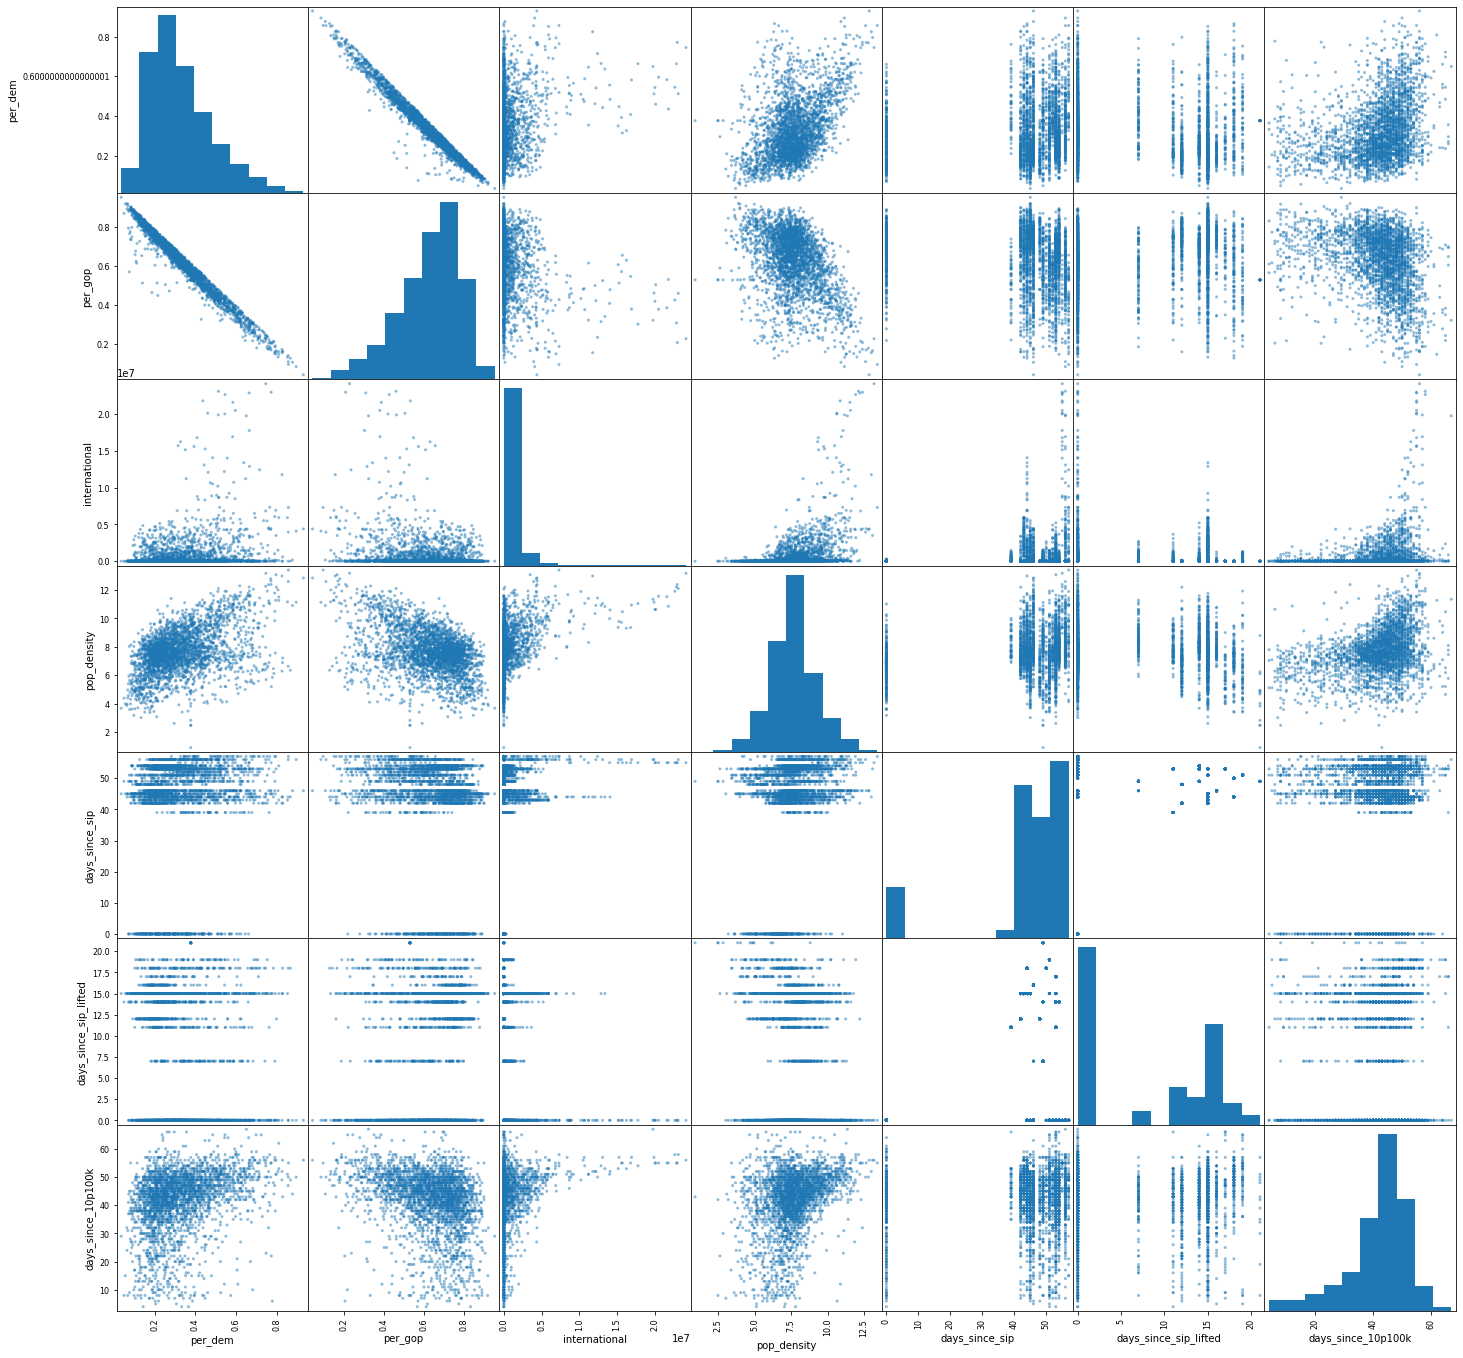

In [350]:
X['pop_density'] = X.apply(lambda x: np.log(x['pop_density']*100+1), axis=1)
xxx = pd.plotting.scatter_matrix(X, figsize=(24,24))

In [329]:
X

,per_dem,per_gop,international,pop_density,days_since_sip,days_since_sip_lifted,days_since_10p100k
fips,,,,,,,
1001,0.239569,0.734358,1.000000,5.879972,42,15,50
1003,0.195653,0.773515,1.000000,5.940227,42,15,45
1005,0.466603,0.522714,1.000000,5.518767,42,15,39
1007,0.214220,0.769662,1.000000,5.585006,42,15,45
1009,0.084699,0.898519,1.000000,5.870958,42,15,43
...,...,...,...,...,...,...,...
56037,0.194046,0.729428,1.000000,3.899449,0,0,40
56039,0.600608,0.321945,1.000000,4.292695,0,0,52
56041,0.149261,0.764187,179025.335253,4.923985,0,0,39


In [340]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2820 entries, 1001 to 56043
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   per_dem                2820 non-null   float64
 1   per_gop                2820 non-null   float64
 2   international          2820 non-null   float64
 3   pop_density            2820 non-null   float64
 4   days_since_sip         2820 non-null   int64  
 5   days_since_sip_lifted  2820 non-null   int64  
 6   days_since_10p100k     2820 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 176.2 KB


Mean cross-validation score: 0.26


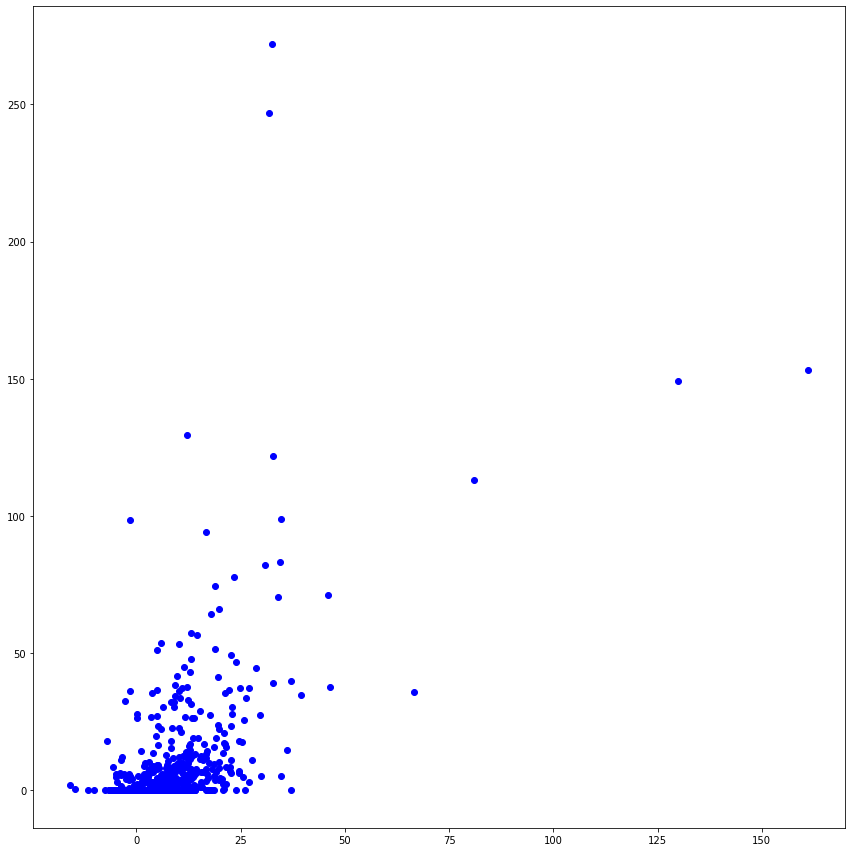

In [351]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
poly.fit(X_train_poly, y_train)
lin = LinearRegression()
lin.fit(X_train_poly, y_train)
X_test_poly = poly.fit_transform(X_test)
predicted = lin.predict(X_test_poly)

fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(predicted, y_test, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(lin, X_train,y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

In [360]:
rms = sqrt(mean_squared_error(y_test, predicted))
rms


428.43902716722715

In [230]:
%pip install xgboost
import xgboost as xgb

In [325]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)


In [353]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Mean cross-validation score: 0.31


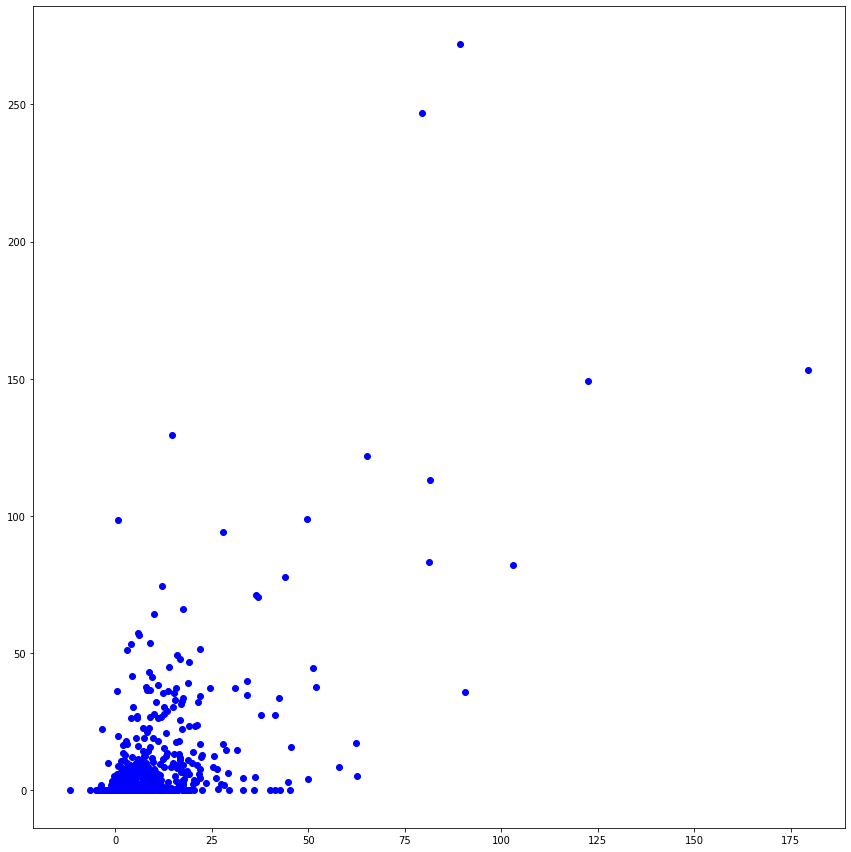

In [354]:
predicted = xgbr.predict(X_test)
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(predicted, y_test, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(xgbr, X_train, y_train, cv=5)

print("Mean cross-validation score: %.2f" % scores.mean())

In [355]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, predicted))
rms

18.84127417793125

In [356]:
y.describe()

count    2820.000000
mean        9.644964
std        21.203961
min         0.000000
25%         0.000000
50%         2.049002
75%         9.017548
max       272.055966
Name: death_rate, dtype: float64